In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import glob
import sys
sys.path.append("../Acdc/")
sys.path.append("../Util/")
sys.path.append("../Analysis/")
sys.path.append("../WaveformPlotter/")
sys.path.append("../Errorcodes/")
import Acdc 
import Analysis
import WaveformPlotter
import matplotlib.pyplot as plt


# Create dictionaries for loading configurations nicely
### Also define some filepaths that should be adjusted based on your environment

In [ ]:
#Structure of this dict:
#key: acdc number
#value: dict with the following keys
#   obj: Acdc object itself
#   config: configuration file path 
#   infiles: list of input data files for that board

#this set of boards is used in the July 2024 proton data at test-beam
acdcs = {44:{"obj":None, "config":"../configs/acdc44.yml", "infiles": [], "pedfiles": []}, \
	43:{"obj":None, "config":"../configs/acdc43.yml", "infiles": [], "pedfiles": []}}

#Configure some data filepaths
#you'll likely want to keep paths as we may be committing/pushing
#multiple paths. Just use a comment
datadir = "../../data/20240701ProtonDataFTBF/"


In [ ]:
#load the waveforms into the events attribute
for acdc_num, a in acdcs.items():
	a["obj"] = Acdc.Acdc(a["config"])

	#the configuration is now parsed, so we can find which station id
	#in order to parse the filetag at the end of the data filenames. 
	bnum = a["obj"].c["station_id"]
	#find all the data files for this board
	a["infiles"] = glob.glob(datadir + f"Raw_Proton*b{bnum}.txt")
	#find all the pedestal files for this board
	a["pedfiles"] = glob.glob(datadir + f"Raw_test*b{bnum}.txt")


	#go file by file and save pre-reduced data for each file.
	#The machinery in the ACDC class can instead handle all files,
	# it is so resource and RAM intensive that I instead opt to save
	#a pre-reduced output file for each input file, looping individually. 
	for f in a["infiles"]:
		#the function can take a list of files, 
		#so I pass just the one we are working on
		a["obj"].load_raw_data_to_events([f]) 

		#loads root file containing linearity data, 
		#calibrates pedestals based on ADC/voltage and does
		#pedestal subtraction, and loads timebase calibration.
		#Within these pedfiles, it finds the closest file to our
		#events without using a future pedfile. 
		a["obj"].calibrate_waveforms(a["pedfiles"])
		a["obj"].write_events_to_file(f.replace(".txt", "_prereduced.p"))




In [ ]:
#Loading the pre-reduced data
#load the waveforms into the events attribute
for acdc_num, a in acdcs.items():
    a["obj"] = Acdc.Acdc(a["config"])

    #the configuration is now parsed, so we can find which station id
    #in order to parse the filetag at the end of the data filenames. 
    bnum = a["obj"].c["station_id"]
    if bnum == 1:
        a["obj"].read_events_from_file("../../LAPPDTestData/Raw_ProtonData_20240701_134140_b1_prereduced.p")
    elif bnum == 0:
        a["obj"].read_events_from_file("../../LAPPDTestData/Raw_ProtonData_20240701_134140_b0_prereduced.p")


In [ ]:
for i in range(256):
    acdcs[43]["obj"].times[0][i] = acdcs[43]["obj"].times[1][i] #In my acdc43.root file, ch 0 is corrupted, so I copy ch 1 to ch 0
for acdc_num, a in acdcs.items():
    a["obj"].reduce_data(event_mask = np.arange(0,500))

In [ ]:
import Util

wp = WaveformPlotter.WaveformPlotter([acdcs[44]["obj"], acdcs[43]["obj"]])

tgt = acdcs[44]["obj"]
#print(acdcs[44]["obj"].times[11])
plt.style.use("~/evanstyle.mplstyle") #change this if you want! or comment
plt.close()
for ev in range(200, 230):
    if(tgt.rqs["time_measured_ch"][ev]!= 0):
        fig, ax = wp.plot_waveforms_separated(station_id=0, event_number=ev)
        plt.vlines(tgt.rqs["ch{}_peak_times".format(int(tgt.rqs["time_measured_ch"][ev]))][ev], 0, 1000, color="red")
        print(int(tgt.rqs["time_measured_ch"][ev]))
        print(int(tgt.rqs["peak_ch"][ev]))
        print(tgt.rqs["ch{}_peak_times".format(int(tgt.rqs["time_measured_ch"][ev]))][ev])
        print(tgt.rqs["wr_phi"][ev])
        print(tgt.rqs["error_codes"][ev])
        plt.plot(np.linspace(0, 25, 256), np.sin(np.linspace(0, 25, 256)/2*np.pi+tgt.rqs["wr_Phi0"][ev])*tgt.rqs["wr_Amplitude"][ev] + tgt.rqs["wr_Offset"][ev])
        #plt.savefig("../../plots/example_waveforms/{:d}_b0.png".format(i))
        plt.show()

#plt.plot(np.linspace(0, 25, 256), tgt.events["waves"][1100][11])

In [ ]:
from scipy import optimize

def gaussianfunc(p,x):
    return p[0]/(p[2]*np.sqrt(2*np.pi))*np.exp(-(x-p[1])**2/(2*p[2]**2))+p[3]

def gaussianfuncSuperposed(p,x):
    return p[0]/(p[2]*np.sqrt(2*np.pi))*np.exp(-(x-p[1])**2/(2*p[2]**2))+p[4]/(p[2]*np.sqrt(2*np.pi))*np.exp(-(x-p[5])**2/(2*p[2]**2))+p[3]

def gaussiandelta(p, x):
    return gaussianfunc(p[0:3],x) + delta(p[3],x)

def delta(p,x):
    return x

def residual(p,func, xvar, yvar, err):
    return np.array((func(p, xvar) - yvar)/err)

def data_fit(p0, func, xvar, yvar, err, tmi=0):
    try:
        fit = optimize.least_squares(residual, p0, args=(func,xvar, yvar, err), verbose=tmi)
    except Exception as error:
        print("Something has gone wrong:",error)
        return p0, np.zeros_like(p0), np.nan, np.nan
    pf = fit['x']

    print()

    try:
        cov = np.linalg.inv(fit['jac'].T.dot(fit['jac']))          
        # This computes a covariance matrix by finding the inverse of the Jacobian times its transpose
        # We need this to find the uncertainty in our fit parameters
    except:
        # If the fit failed, print the reason
        print('Fit did not converge')
        print('Result is likely a local minimum')
        print('Try changing initial values')
        print('Status code:', fit['status'])
        print(fit['message'])
        return pf, np.zeros_like(pf), np.nan, np.nan
            #You'll be able to plot with this, but it will not be a good fit.

    chisq = sum(residual(pf, func, xvar, yvar, err) **2)
    dof = len(xvar) - len(pf)
    red_chisq = chisq/dof
    pferr = np.sqrt(np.diagonal(cov)) # finds the uncertainty in fit parameters by squaring diagonal elements of the covariance matrix
    print('Converged with chi-squared {:.2f}'.format(chisq))
    print('Number of degrees of freedom, dof = {:.2f}'.format(dof))
    print('Reduced chi-squared {:.2f}'.format(red_chisq))
    print()
    Columns = ["Parameter #","Initial guess values:", "Best fit values:", "Uncertainties in the best fit values:"]
    print('{:<11}'.format(Columns[0]),'|','{:<24}'.format(Columns[1]),"|",'{:<24}'.format(Columns[2]),"|",'{:<24}'.format(Columns[3]))
    for num in range(len(pf)):
        print('{:<11}'.format(num),'|','{:<24.3e}'.format(p0[num]),'|','{:<24.3e}'.format(pf[num]),'|','{:<24.3e}'.format(pferr[num]))
    return pf, pferr, chisq,dof

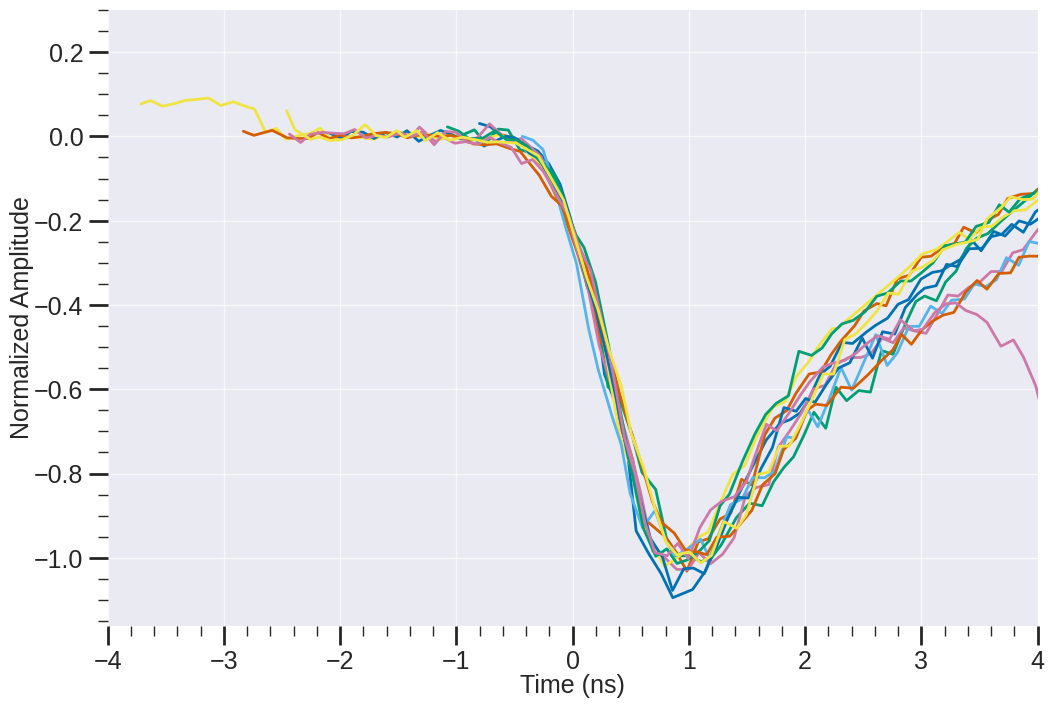

4.6121304068053215
0.3356306067626129


NameError: name 'data_fit' is not defined

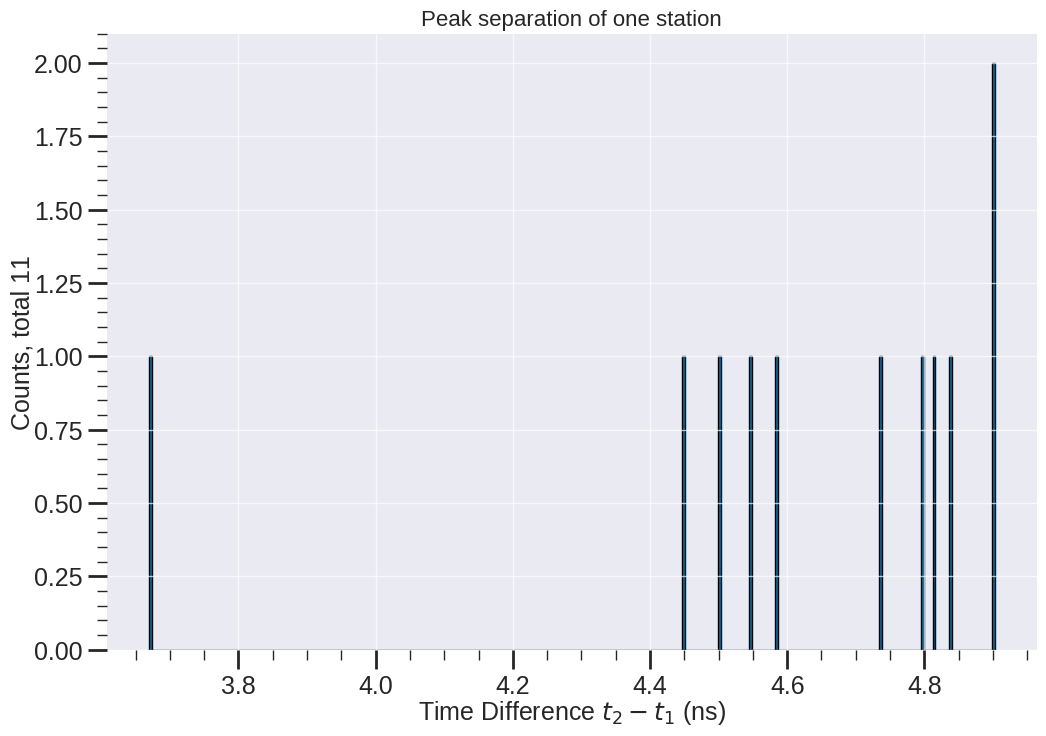

In [93]:
# Waveform CFD amd Peak time separation analysis

tgt = acdcs[44]["obj"]
#print(acdcs[44]["obj"].times[11])
plt.style.use("~/evanstyle.mplstyle") #change this if you want! or comment
plt.close()
peak_time_separation = []
for ev in range(230, 250):
    if(tgt.rqs["time_measured_ch"][ev]!= 0):
        ch = int(tgt.rqs["time_measured_ch"][ev])
        if (tgt.rqs["ch{}_peak_times".format(ch)][ev][0] > 0):
            interpolated_zero = np.interp(tgt.rqs["ch{}_peak_times".format(ch)][ev][0],tgt.times_rolled[ev][ch], tgt.events["waves"][ev][ch])
            plt.plot(tgt.times_rolled[ev][ch] - tgt.rqs["ch{}_peak_times".format(ch)][ev][0], (tgt.events["waves"][ev][ch]) / tgt.rqs["ch{}_amplitudes".format(ch)][ev])
            #plt.plot(tgt.times_rolled[ev][ch] - tgt.rqs["ch{}_peak_times".format(ch)][ev][0], tgt.events["waves"][ev][ch] )

            #Print baseline parameters next to the waveform
            #First get the first point of the plot
            x_0 = tgt.times_rolled[ev][ch][0] - tgt.rqs["ch{}_peak_times".format(ch)][ev][0]
            y_0 = (tgt.events["waves"][ev][ch][0]) / tgt.rqs["ch{}_amplitudes".format(ch)][ev]
            y_0 = tgt.events["waves"][ev][ch][0]

            #plt.text(x_0, y_0, "trigger_end:{:.2f}".format(tgt.rqs["corrupted_samples_from_begin"][ev]), fontsize=6,verticalalignment='top')
            #plt.text(x_0, y_0, "{:.2f}, {:.2f}".format(tgt.rqs["ch{}_baseline".format(ch)][ev], tgt.rqs["ch{}_baseline_precise".format(ch)][ev]), fontsize=6,verticalalignment='top')
            #Print error codes next to the waveform
            #plt.text(x_0, y_0, str(tgt.rqs["ch{}_warnings".format(ch)][ev]), fontsize=6,verticalalignment='bottom')
            peak_time_separation.append(tgt.rqs["ch{}_peak_times".format(ch)][ev][1] - tgt.rqs["ch{}_peak_times".format(ch)][ev][0])
        
        #plt.savefig("../../plots/example_waveforms/{:d}_b0.png".format(i))
plt.xlim(-4, 4)
plt.xlabel("Time (ns)")
plt.ylabel("Normalized Amplitude")
plt.show()
peak_time_separation = np.array(peak_time_separation)
print(np.mean(peak_time_separation))
print(np.std(peak_time_separation))

plt.hist(peak_time_separation, bins=300)
plt.xlabel("Time Difference $t_2 - t_1$ (ns)")
plt.ylabel("Counts, total {}".format(np.size(peak_time_separation)))
plt.title("Peak separation of one station")

y2, bin_edges = np.histogram(peak_time_separation, bins=300)
x2 = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate bin centers
dy2 = np.sqrt(y2+1)  # Assuming Poisson statistics for the errors
p0 = [np.max(y2)/2, x2[np.argmax(y2)], 0.2, 0]  # Initial guess for the fit parameters
pf1, pferr1, chisq1, dof1 = data_fit(p0, gaussianfunc, x2, y2, dy2)
plt.plot(x2, gaussianfunc(pf1, x2), 'b-', label='fit',zorder=11)
plt.xlim(3,6)

textfit = '$f(x) = N/\sigma\sqrt{{2\pi}}e^{-(x-\mu)^2/2\sigma^2}$ \n' 
textfit += '$N = {:.2f} \pm {:.2f}$ counts\n'.format(pf1[0],pferr1[0]) 
textfit +='$\mu = {:.3f} \pm {:.3f}ns$ \n'.format(pf1[1],pferr1[1])
textfit += '$\sigma = {:.3f} \pm {:.3f}ns$\n'.format(pf1[2],pferr1[2])
plt.text(3, 50, textfit , fontsize=12,verticalalignment='top')

plt.show()


#plt.plot(np.linspace(0, 25, 256), tgt.events["waves"][1100][11])

In [ ]:
#Time of flight between two stations

an = Analysis.Analysis("../configs/analysis.yml", acdcs)
an.construct_tracks(acdcs[44]["obj"], acdcs[43]["obj"])
print(an.tracks["error_codes"])
error_mask = [len(an.tracks["error_codes"][trk])==0 for trk in range(len(an.tracks["error_codes"]))]
plt.hist(an.tracks["time_of_flight_ns"][error_mask], bins=200)
plt.xlabel("Time Difference $t_2 - t_1$ (ns)")
plt.ylabel("# of Coincidence Pairs, total {}".format(np.count_nonzero(error_mask)))
plt.title("Subsecond WR Counter Comparison Between Two Stations, After Coincidence Cut")

y2, bin_edges = np.histogram(an.tracks["time_of_flight_ns"][error_mask], bins=200)
x2 = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate bin centers
dy2 = np.sqrt(y2+1)  # Assuming Poisson statistics for the errors
p0 = [np.max(y2)/2, x2[np.argmax(y2)], 0.2, 0]  # Initial guess for the fit parameters
pf1, pferr1, chisq1, dof1 = data_fit(p0, gaussianfunc, x2, y2, dy2)
plt.plot(x2, gaussianfunc(pf1, x2), 'b-', label='fit',zorder=11)
textfit = '$f(x) = N/\sigma\sqrt{{2\pi}}e^{-(x-\mu)^2/2\sigma^2}$ \n' 
textfit += '$N = {:.2f} \pm {:.2f}$ counts\n'.format(pf1[0],pferr1[0]) 
textfit +='$\mu = {:.3f} \pm {:.3f}ns$ \n'.format(pf1[1],pferr1[1])
textfit += '$\sigma = {:.3f} \pm {:.3f}ns$\n'.format(pf1[2],pferr1[2])
plt.text(0, 100, textfit , fontsize=12,verticalalignment='top')
plt.xlim(0, 4)


In [ ]:
# Position distribution of one station

filter = [acdcs[44]["obj"].rqs["hpos"][ev] > 0 and acdcs[44]["obj"].rqs["vpos"][ev] > 0 for ev in range(len(acdcs[44]["obj"].rqs["hpos"]))]
data_h = np.array(acdcs[44]["obj"].rqs["hpos"])[filter]
print(np.mean(data_h))
print(np.std(data_h))

plt.hist(data_h, bins=200)
plt.xlabel("Horizontal Position (mm)")
plt.ylabel("# of Coincidence Pairs, total {}".format(np.count_nonzero(error_mask)))
plt.title("Horizontal Position Distribution of one station")

y2, bin_edges = np.histogram(data_h, bins=200)
x2 = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate bin centers
dy2 = np.sqrt(y2+1)  # Assuming Poisson statistics for the errors
p0 = [np.max(y2)/2, x2[np.argmax(y2)], 0.2, 0]  # Initial guess for the fit parameters
pf1, pferr1, chisq1, dof1 = data_fit(p0, gaussianfunc, x2, y2, dy2)
#plt.plot(x2, gaussianfunc(pf1, x2), 'b-', label='fit',zorder=11)
textfit = '$f(x) = N/\sigma\sqrt{{2\pi}}e^{-(x-\mu)^2/2\sigma^2}$ \n' 
textfit += '$N = {:.2f} \pm {:.2f}$ counts\n'.format(pf1[0],pferr1[0]) 
textfit +='$\mu = {:.3f} \pm {:.3f}ns$ \n'.format(pf1[1],pferr1[1])
textfit += '$\sigma = {:.3f} \pm {:.3f}ns$\n'.format(pf1[2],pferr1[2])
plt.text(0, 100, textfit , fontsize=12,verticalalignment='top')
plt.show()


data_v = np.array(acdcs[44]["obj"].rqs["vpos"])[filter]

print(np.mean(data_v))
print(np.std(data_v))
plt.hist(data_v, bins=200)
plt.xlabel("Vertical Position (mm)")
plt.ylabel("# of Coincidence Pairs, total {}".format(np.count_nonzero(error_mask)))
plt.title("Vertical Position Distribution of one station")

y2, bin_edges = np.histogram(data_v, bins=200)
x2 = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate bin centers
dy2 = np.sqrt(y2+1)  # Assuming Poisson statistics for the errors
p0 = [np.max(y2)/2, x2[np.argmax(y2)], 0.2, 0]  # Initial guess for the fit parameters
pf1, pferr1, chisq1, dof1 = data_fit(p0, gaussianfunc, x2, y2, dy2)
#plt.plot(x2, gaussianfunc(pf1, x2), 'b-', label='fit',zorder=11)
textfit = '$f(x) = N/\sigma\sqrt{{2\pi}}e^{-(x-\mu)^2/2\sigma^2}$ \n' 
textfit += '$N = {:.2f} \pm {:.2f}$ counts\n'.format(pf1[0],pferr1[0]) 
textfit +='$\mu = {:.3f} \pm {:.3f}ns$ \n'.format(pf1[1],pferr1[1])
textfit += '$\sigma = {:.3f} \pm {:.3f}ns$\n'.format(pf1[2],pferr1[2])
plt.text(0, 100, textfit , fontsize=12,verticalalignment='top')

In [ ]:
#Track position difference between two stations

station1_event_ids =  an.tracks["event_ids"][error_mask][:, 0]
station2_event_ids =  an.tracks["event_ids"][error_mask][:,1]
data_h = np.array(acdcs[44]["obj"].rqs["hpos"])[station1_event_ids] - np.array(acdcs[43]["obj"].rqs["hpos"])[station2_event_ids]
print(np.mean(data_h))
print(np.std(data_h))

plt.hist(data_h, bins=200)
plt.xlabel("Horizontal Position (mm)")
plt.ylabel("# of Coincidence Pairs, total {}".format(np.count_nonzero(error_mask)))
plt.title("Horizontal Position Difference of particle events across two stations")

y2, bin_edges = np.histogram(data_h, bins=200)
x2 = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate bin centers
dy2 = np.sqrt(y2+1)  # Assuming Poisson statistics for the errors
p0 = [np.max(y2)/2, x2[np.argmax(y2)], 10, 0]  # Initial guess for the fit parameters
pf1, pferr1, chisq1, dof1 = data_fit(p0, gaussianfunc, x2, y2, dy2)
plt.plot(x2, gaussianfunc(pf1, x2), 'b-', label='fit',zorder=11)
textfit = '$f(x) = N/\sigma\sqrt{{2\pi}}e^{-(x-\mu)^2/2\sigma^2}$ \n' 
textfit += '$N = {:.2f} \pm {:.2f}$ counts\n'.format(pf1[0],pferr1[0]) 
textfit +='$\mu = {:.3f} \pm {:.3f}mm$ \n'.format(pf1[1],pferr1[1])
textfit += '$\sigma = {:.3f} \pm {:.3f}mm$\n'.format(pf1[2],pferr1[2])
plt.text(200, 100, textfit , fontsize=12,verticalalignment='top')
plt.show()

data_v = np.array(acdcs[44]["obj"].rqs["vpos"])[station1_event_ids] - np.array(acdcs[43]["obj"].rqs["vpos"])[station2_event_ids]
plt.hist(data_v, bins=200)
plt.xlabel("Vertical Position (mm)")
plt.ylabel("# of Coincidence Pairs, total {}".format(np.count_nonzero(error_mask)))
plt.title("Vertical Position Difference of particle events across two stations")

y2, bin_edges = np.histogram(data_v, bins=200)
x2 = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate bin centers
dy2 = np.sqrt(y2+1)  # Assuming Poisson statistics for the errors
p0 = [np.max(y2)/2, x2[np.argmax(y2)], 10, 0]  # Initial guess for the fit parameters
pf1, pferr1, chisq1, dof1 = data_fit(p0, gaussianfunc, x2, y2, dy2)
plt.plot(x2, gaussianfunc(pf1, x2), 'b-', label='fit',zorder=11)
textfit = '$f(x) = N/\sigma\sqrt{{2\pi}}e^{-(x-\mu)^2/2\sigma^2}$ \n' 
textfit += '$N = {:.2f} \pm {:.2f}$ counts\n'.format(pf1[0],pferr1[0]) 
textfit +='$\mu = {:.3f} \pm {:.3f}mm$ \n'.format(pf1[1],pferr1[1])
textfit += '$\sigma = {:.3f} \pm {:.3f}mm$\n'.format(pf1[2],pferr1[2])
plt.text(200, 100, textfit , fontsize=12,verticalalignment='top')
plt.show()

In [ ]:
#Track Angle Analysis

print(np.mean(an.tracks["polar_angle_phi"][error_mask]))
print(np.std(an.tracks["polar_angle_phi"][error_mask]))

plt.hist(an.tracks["polar_angle_phi"][error_mask], bins=200)
plt.xlabel("Polar Angle Phi (rad)")
plt.ylabel("# of Coincidence Pairs, total {}".format(np.count_nonzero(error_mask)))
plt.title("Subsecond WR Counter Comparison Between Two Stations, After Coincidence Cut")

y2, bin_edges = np.histogram(an.tracks["polar_angle_phi"][error_mask], bins=200)
x2 = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate bin centers
dy2 = np.sqrt(y2+1)  # Assuming Poisson statistics for the errors
p0 = [np.max(y2)/2, x2[np.argmax(y2)], 0.2, 0]  # Initial guess for the fit parameters
pf1, pferr1, chisq1, dof1 = data_fit(p0, gaussianfunc, x2, y2, dy2)
#plt.plot(x2, gaussianfunc(pf1, x2), 'b-', label='fit',zorder=11)
textfit = '$f(x) = N/\sigma\sqrt{{2\pi}}e^{-(x-\mu)^2/2\sigma^2}$ \n' 
textfit += '$N = {:.2f} \pm {:.2f}$ counts\n'.format(pf1[0],pferr1[0]) 
textfit +='$\mu = {:.3f} \pm {:.3f}ns$ \n'.format(pf1[1],pferr1[1])
textfit += '$\sigma = {:.3f} \pm {:.3f}ns$\n'.format(pf1[2],pferr1[2])
#plt.text(0, 100, textfit , fontsize=12,verticalalignment='top')
plt.show()

print(np.mean(an.tracks["polar_angle_theta"][error_mask]))
print(np.std(an.tracks["polar_angle_theta"][error_mask]))
plt.hist(an.tracks["polar_angle_theta"][error_mask], bins=200)
plt.xlabel("Polar Angle Theta (rad)")
plt.ylabel("# of Coincidence Pairs, total {}".format(np.count_nonzero(error_mask)))
plt.title("Subsecond WR Counter Comparison Between Two Stations, After Coincidence Cut")

y2, bin_edges = np.histogram(an.tracks["polar_angle_theta"][error_mask], bins=200)
x2 = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate bin centers
dy2 = np.sqrt(y2+1)  # Assuming Poisson statistics for the errors
p0 = [np.max(y2)/2, x2[np.argmax(y2)], 0.2, 0]  # Initial guess for the fit parameters
pf1, pferr1, chisq1, dof1 = data_fit(p0, gaussianfunc, x2, y2, dy2)
#plt.plot(x2, gaussianfunc(pf1, x2), 'b-', label='fit',zorder=11)
textfit = '$f(x) = N/\sigma\sqrt{{2\pi}}e^{-(x-\mu)^2/2\sigma^2}$ \n' 
textfit += '$N = {:.2f} \pm {:.2f}$ counts\n'.format(pf1[0],pferr1[0]) 
textfit +='$\mu = {:.3f} \pm {:.3f}ns$ \n'.format(pf1[1],pferr1[1])
textfit += '$\sigma = {:.3f} \pm {:.3f}ns$\n'.format(pf1[2],pferr1[2])
#plt.text(0, 100, textfit , fontsize=12,verticalalignment='top')